# nn-basic-conv-compare
### (topic: neural networks / machine learning)
### https://github.com/yoshc
---

### Content:
1. Building a **basic neural network** and a **convolutional neural network** for the MNIST dataset
2. Comparing their accuracy
3. Determining which images are **recognized by the _convolutional_ neural network, but not by the _basic neural network_**, and plotting them  
---

### Setting the hyperparameters of the neural networks

In [1]:
# hyperparameters of the basic neural network

# First hidden layer
NN_BASIC_LAYER_1_NUMBER_NEURONS = 400
NN_BASIC_LAYER_1_ACTIVATION = "relu" # or sigmoid?
NN_BASIC_LAYER_1_DROPOUT = 0.2
# Second hidden layer
NN_BASIC_LAYER_2_NUMBER_NEURONS = 100
NN_BASIC_LAYER_2_ACTIVATION = "relu" # or sigmoid?
NN_BASIC_LAYER_2_DROPOUT = 0.2
# Non layer specific hyperparameters
NN_BASIC_BATCH_SIZE = 128
NN_BASIC_EPOCHS = 10

## Needed imports
We need keras, numpy and matplotlib.
I am using the TensorFlow backend in keras

In [2]:
import keras
import numpy as np
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation

/Users/josh/.virtualenvs/machinelearning/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## 1. Building a basic neural network and a convolutional neural network for the MNIST dataset
### 1.1 Loading and preparing the data
#### 1.1.1 Loading MNIST dataset

In [3]:
mnist = keras.datasets.mnist.load_data()

#### 1.1.2 Splitting up the data

In [4]:
(X_train, y_train), (X_test, y_test) = mnist

X is the image data, y is the label data

#### 1.1.3 Checking the shape and taking a peek into the data by visualizing it

In [5]:
print("train data shape=", X_train.shape, " train labels shape=", y_train.shape, sep="")
print("test data shape=", X_test.shape, " test labels shape=", y_test.shape, sep="")
print("This means we have have", X_train.shape[0], "train images and", X_test.shape[0], "test images")

train data shape=(60000, 28, 28) train labels shape=(60000,)
test data shape=(10000, 28, 28) test labels shape=(10000,)
This means we have have 60000 train images and 10000 test images


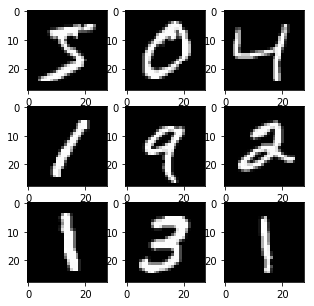

Should be [5, 0, 4, 1, 9, 2, 1, 3, 1]


In [6]:
# Visualizing the first 9 images using matplotlib
fig=plt.figure(figsize=(5, 5))
columns, rows = 3,3
for i in range(0, rows*columns):
    img = X_train[i]
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(img, cmap="gray")
plt.show()

# Verifying it
print("Should be", [label for label in y_train[:columns*rows]])

#### 1.1.4 Converting image data from [0; 255] to [0.0f, 1.0f]
Our neural network uses float values between 0.0 and 1.0, but the dataset uses integer values between 0 and 255

In [7]:
X_train = X_train.astype("float32")
X_test = X_test.astype("float32")
X_train /= 255
X_test /= 255

#### 1.1.5 Reshaping label data
The label data looks like [5, 0, 4, 1, 9, ...], but it has to be categorical. For example the label "5" should be represented by a float ndarray filled with zeros, except for the index 5 should be 1.0  
example: 5 -> [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0]  
There is also a keras util function for that purpose but it's easy to write that function ourselves since it's trivial

In [8]:
def to_categorical(arr):
    target_shape = (len(arr), 10)
    data = np.zeros(target_shape)
    for i in range(len(arr)):
        data[i, arr[i]] = 1.0
    return data

In [9]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
# Verifying it
print(y_train[0]) # should be [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.] like in the example above

[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


#### 1.1.6 Reshaping data for basic neural network
The neural network input should be 1-dimensional, whereas the convolutional network takes takes the data 2-dimensional as it is.  
We basically want to reshape the input from (60000, 28, 28) to (60000, 784)

In [10]:
pixels = X_train.shape[1] * X_train.shape[2] # mnist images are 28*28 pixels = 784 pixels

In [11]:
X_train_2dim = X_train.reshape((X_train.shape[0], pixels))
X_test_2dim = X_test.reshape((X_test.shape[0], pixels))

In [12]:
print(X_train_2dim.shape, X_test_2dim.shape)

(60000, 784) (10000, 784)


Exactly what we wanted! The data is now prepared!

### 1.2 Now the fun part: Building the neural networks

We will be building two models: one for the _basic neural network_ and one for the _convolutional neural network_

#### 1.2.1 Building the basic neural network model

In [13]:
# First model: basic neural network
model_basic = Sequential()

# Layer 1
model_basic.add(Dense(NN_BASIC_LAYER_1_NUMBER_NEURONS, input_shape=(pixels,)))
# this is why we changed the input shape for the basic neural network ^
# otherwise the shape would not be correct
model_basic.add(Activation(NN_BASIC_LAYER_1_ACTIVATION))
model_basic.add(Dropout(NN_BASIC_LAYER_1_DROPOUT))
# Layer 2
model_basic.add(Dense(NN_BASIC_LAYER_2_NUMBER_NEURONS, input_shape=(pixels,)))
model_basic.add(Activation(NN_BASIC_LAYER_2_ACTIVATION))
model_basic.add(Dropout(NN_BASIC_LAYER_2_DROPOUT))
# Output Layer (of course needs 10 neurons because we have 10 different numbers (0-9))
model_basic.add(Dense(10))
model_basic.add(Activation("softmax"))

In [23]:
# Print a summary of the basic neural network
print(model_basic.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 400)               314000    
_________________________________________________________________
activation_1 (Activation)    (None, 400)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 400)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               40100     
_________________________________________________________________
activation_2 (Activation)    (None, 100)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                1010      
__________

#### 1.2.2 Building the convolutional neural network model

In [14]:
# TODO conv

In [ ]:
# Print a summary of the conv neural network
# print(model_conv.summary())

#### 1.2.3 Compile both models

In [15]:
model_basic.compile(loss="categorical_crossentropy", optimizer="adam")
# TODO conv

#### 1.2.4 Training the model to fit the data

_This is where the machine learning process takes place_

In [16]:
model_basic.fit(X_train_2dim, y_train,
          batch_size=NN_BASIC_BATCH_SIZE, epochs=NN_BASIC_EPOCHS,
          verbose=1)

Epoch 1/10
60000/60000 [==============================] - 3s 53us/step - loss: 0.3128
Epoch 2/10
60000/60000 [==============================] - 3s 48us/step - loss: 0.1247
Epoch 3/10
60000/60000 [==============================] - 3s 48us/step - loss: 0.0888
Epoch 4/10
60000/60000 [==============================] - 3s 48us/step - loss: 0.0706
Epoch 5/10
60000/60000 [==============================] - 3s 50us/step - loss: 0.0594
Epoch 6/10
60000/60000 [==============================] - 3s 48us/step - loss: 0.0485
Epoch 7/10
60000/60000 [==============================] - 3s 47us/step - loss: 0.0444
Epoch 8/10
60000/60000 [==============================] - 3s 47us/step - loss: 0.0390
Epoch 9/10
60000/60000 [==============================] - 3s 50us/step - loss: 0.0350
Epoch 10/10
60000/60000 [==============================] - 3s 48us/step - loss: 0.0316


#### 1.2.5 Evaluating the accuracy of each neural network

In [25]:
score_basic = model_basic.evaluate(X_test_2dim, y_test)
# TODO conv
accuracy_basic = 1.0 - score
print("Accuracy of the basic neural network:", (accuracy_basic*100), "%")
#print("Accuracy of the convolutional neural network:", accuracy_conv)

10000/10000 [==============================] - 0s 42us/step
Accuracy of the basic neural network: 94.35161199111434 %


In [30]:
pred_basic = model_basic.predict(X_test_2dim)
# TODO conv

We need a function to convert the prediction from a array of propabilities to an int value. This integer represents the number the neural network guesses

In [33]:
def pred_to_int(pred_result):
    curr_max = 0.0
    max_index = -1
    for i, x in enumerate(pred_result):
        if(x > curr_max):
            max_index = i
            curr_max = x
    return max_index

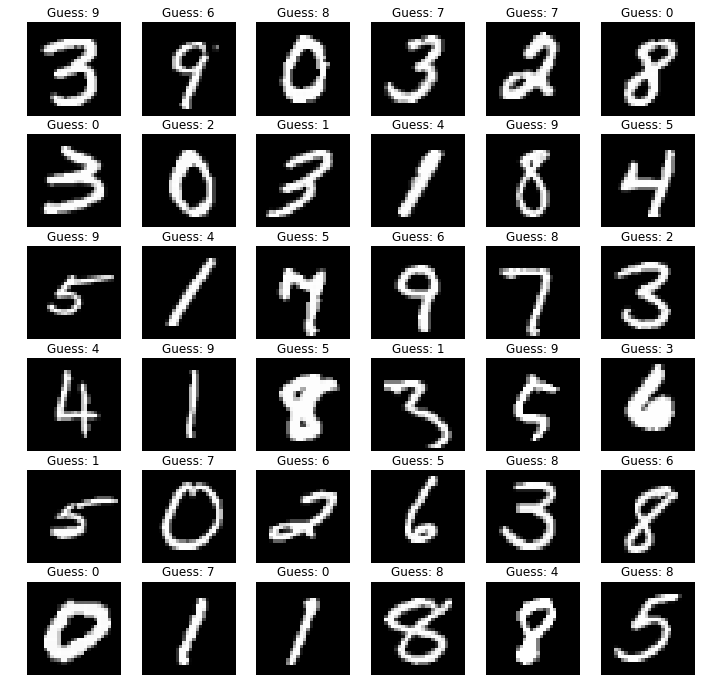

Wrong guesses: 165 out of 10000


In [66]:
wrong_indices = []
for i in range(len(y_test)):
    guess = pred_to_int(pred_basic[i])
    confidence = pred_basic[i, guess]
    actual = pred_to_int(y_test[i])
    if guess != actual:
        #print("The guess of image", i, " is wrong!")
        #print("The guess is", guess, "but it actually is", actual, "(confidence=", confidence, ")")
        wrong_indices.append(i)

fig =plt.figure(figsize=(12, 12))

columns, rows = 6, 6
for i in range(0, len(wrong_indices)):
    index = wrong_indices[i]
    if i > columns*rows-1:
        break
    img = X_train[index]
    subplot = fig.add_subplot(rows, columns, i+1)
    subplot.axis("off")
    #subplot.gca().axes.get_yaxis().set_visible(False)
    plt.title("Guess: " + str(pred_to_int(pred_basic[index])))
    plt.imshow(img, cmap="gray")
plt.show()
print("Wrong guesses:", len(wrong_indices), "out of", len(X_test))